In [1]:
import os
import time
import glob
import re
from functools import reduce
import numpy as np
import uproot
import uproot_methods
import awkward
import pandas as pd
from klepto.archives import dir_archive


import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib.pyplot as plt



In [2]:
#define processor

class WHhadProcessor(processor.ProcessorABC):
    def __init__(self):
        
        #define bins
        dataset_axis         = hist.Cat("dataset", "Primary dataset")
        pt_axis              = hist.Bin("pt", r"$p_{T}$ (GeV)", 500, 0, 2000)
        mass_axis            = hist.Bin("mass", r"$mass$ (GeV)", 100, 0, 2500)
        eta_axis             = hist.Bin("eta", r"$\eta$", 80, -4, 4)
        phi_axis             = hist.Bin("phi", r"$\Delta \phi$", 80, 0, 8)
        r_axis               = hist.Bin("r", r"$\Delta R$", 80, 0, 4)
        multiplicity_axis    = hist.Bin("multiplicity", r"N", 30, -0.5, 29.5)
        
        
        #define dictionary for plots
        self._accumulator = processor.dict_accumulator({
            "met":                          hist.Hist("Counts", dataset_axis, pt_axis),
            "ht":                           hist.Hist("Counts", dataset_axis, pt_axis),
            "njets":                        hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "bjets":                        hist.Hist("Counts", dataset_axis, multiplicity_axis),            
            "max_mt_b_met" :                hist.Hist("Counts", dataset_axis, mass_axis),
            "min_mt_b_met" :                hist.Hist("Counts", dataset_axis, mass_axis),
            "min_dphi_met_j" :              hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_wmch" :           hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_wmdh" :           hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_leadj" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_leadbj" :               hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_leadnbj" :              hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_subleadj" :             hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_subleadbj" :            hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_H_subleadnbj" :           hist.Hist("Counts", dataset_axis, phi_axis),
            "dr_H_leadj" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dr_H_leadbj" :                 hist.Hist("Counts", dataset_axis, r_axis),
            "dr_H_leadnbj" :                hist.Hist("Counts", dataset_axis, r_axis),
            "dr_H_subleadj" :               hist.Hist("Counts", dataset_axis, r_axis),
            "dr_H_subleadbj" :              hist.Hist("Counts", dataset_axis, r_axis),
            "dr_H_subleadnbj" :             hist.Hist("Counts", dataset_axis, r_axis),            "dphi_W_leadj" :                    hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_leadj" :                hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_leadbj" :               hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_leadnbj" :              hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_subleadj" :             hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_subleadbj" :            hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_W_subleadnbj" :           hist.Hist("Counts", dataset_axis, phi_axis),
            "dr_W_leadj" :                  hist.Hist("Counts", dataset_axis, r_axis),
            "dr_W_leadbj" :                 hist.Hist("Counts", dataset_axis, r_axis),
            "dr_W_leadnbj" :                hist.Hist("Counts", dataset_axis, r_axis),
            "dr_W_subleadj" :               hist.Hist("Counts", dataset_axis, r_axis),
            "dr_W_subleadbj" :              hist.Hist("Counts", dataset_axis, r_axis),
            "dr_W_subleadnbj" :             hist.Hist("Counts", dataset_axis, r_axis),
            "dphi_MET_leadj":               hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_MET_leadbj":              hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_MET_leadnbj":             hist.Hist("Counts", dataset_axis, phi_axis), 
            "dphi_MET_subleadj":            hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_MET_subleadbj":           hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_MET_subleadnbj":          hist.Hist("Counts", dataset_axis, phi_axis), 
            "dphi_MET_leadH":               hist.Hist("Counts", dataset_axis, phi_axis),
            "dphi_MET_leadW":               hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_j3":              hist.Hist("Counts", dataset_axis, phi_axis),
            "min_dphi_met_j4":              hist.Hist("Counts", dataset_axis, phi_axis),
            })

    
    @property
    def accumulator(self):
        return self._accumulator

    
    def process(self, df):
        
        output = self.accumulator.identity()
        
        dataset = df['dataset']

        #MET
        metphi = df["MET_phi"]
        metpt = df["MET_pt"]
        
        #leptons
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        
        muons = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt=df['Muon_pt'].content, 
            eta=df['Muon_eta'].content, 
            phi=df['Muon_phi'].content,
            mass=df['Muon_mass'].content,
            pdgid=df['Muon_pdgId'].content,
            mini_iso=df['Muon_miniPFRelIso_all'].content, 
            looseid =df['Muon_looseId'].content
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
            df['nTau'],
            pt=df['Tau_pt'].content, 
            eta=df['Tau_eta'].content, 
            phi=df['Tau_phi'].content,
            mass=df['Tau_mass'].content,
            decaymode=df['Tau_idDecayMode'].content,
            newid=df['Tau_idMVAnewDM2017v2'].content,
        )
        
        isotracks = awkward.JaggedArray.zip(
            pt=df['IsoTrack_pt'], 
            eta=df['IsoTrack_eta'], 
            phi=df['IsoTrack_phi'], 
            rel_iso=df['IsoTrack_pfRelIso03_all'], 
        )
        
        #jets
        jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'].content, 
            eta=df['Jet_eta'].content, 
            phi=df['Jet_phi'].content,
            btag=df['Jet_btagDeepB'].content, 
            jetid=df['Jet_jetId'].content, 
            mass=df['Jet_mass'].content,
        )
        fatjets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'].content, 
            eta=df['FatJet_eta'].content, 
            phi=df['FatJet_phi'].content, 
            mass=df['FatJet_mass'].content, 
            softdrop=df["FatJet_msoftdrop"].content,  
            fromH = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            fromW_MD = df['FatJet_deepTagMD_WvsQCD'].content, 
            fromW_MC = df['FatJet_deepTag_WvsQCD'].content
        )
        
        #ak4's
        goodjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0))
        goodjets = jets[goodjcut]
        njets = goodjets.counts
        jetpt_sorted = goodjets.pt.argsort(ascending=False)
        leadjet = goodjets[jetpt_sorted==0]
        subleadjet = goodjets[jetpt_sorted==1]
        leadjets = goodjets[jetpt_sorted <= 1]
        leadjets3 = goodjets[jetpt_sorted <= 2]
        leadjets4 = goodjets[jetpt_sorted <= 4]
      
        bjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag>0.4184))
        bjets = jets[bjcut]
        numbjets = bjets.counts
        bjetpt = bjets.pt
        bjetpt_sorted = bjetpt.argsort(ascending=False)
        leadbjet = bjets[bjetpt_sorted==0]
        subleadbjet = bjets[bjetpt_sorted==1]
        leadbjets = bjets[bjetpt_sorted <= 1]
            
        nonbjcut = ((jets.pt>30) & (abs(jets.eta)<2.4) & (jets.jetid>0) & (jets.btag<0.4184))
        nbjets = jets[nonbjcut]
        nbjetpt_sorted = nbjets.pt.argsort(ascending=False)
        leadnbjet = nbjets[nbjetpt_sorted==0]
        subleadnbjet = nbjets[nbjetpt_sorted==1]
        leadnbjets = nbjets[nbjetpt_sorted <= 1]

        
        #ak8's
        goodfjcut = ((fatjets.pt > 200))
        goodfatjets = fatjets[goodfjcut]
        
        htagcut = ((fatjets.pt > 200) & (fatjets.fromH > 0.8365))
        htagged = fatjets[htagcut]
        htagpt_sorted = htagged.pt.argsort(ascending=False)
        leadhtag = htagged[htagpt_sorted==0]
        subleadhtag = htagged[htagpt_sorted==1]
        leadhtags = htagged[htagpt_sorted <= 1]
        
        wtagcut_mc = ((fatjets.pt > 200) & (fatjets.fromW_MC > 0.918) & (fatjets.fromH < 0.8365))
        wtagcut_md = ((fatjets.pt > 200) & (fatjets.fromW_MD > 0.704) & (fatjets.fromH < 0.8365))
        wtagged_mc = fatjets[wtagcut_mc]
        wtagged_md = fatjets[wtagcut_md]
        wtagmcpt_sorted = wtagged_mc.pt.argsort(ascending=False)
        leadwmctag = wtagged_mc[wtagmcpt_sorted==0]
        subleadwmctag = wtagged_mc[wtagmcpt_sorted==1]
        leadwmctags = wtagged_mc[wtagmcpt_sorted <= 1]
        wtagmdpt_sorted = wtagged_md.pt.argsort(ascending=False)
        leadwmdtag = wtagged_md[wtagmdpt_sorted==0]
        subleadwmdtag = wtagged_md[wtagmdpt_sorted==1]
        leadwmdtags = wtagged_md[wtagmdpt_sorted <= 1]
 
        WmcH = leadwmctag.cross(leadhtag)
        WmcHpt_sorted = WmcH.pt.argsort(ascending=False)
        leadWmcleadH = WmcH[WmcHpt_sorted <=1]

        WmdH = leadwmdtag.cross(leadhtag)
        WmdHpt_sorted = WmdH.pt.argsort(ascending=False)
        leadWmdleadH = WmdH[WmdHpt_sorted <=1]

        #match jets
        
        leadjleadH = leadhtag.cross(leadjet)
        leadbjleadH = leadhtag.cross(leadbjet)
        leadnbjleadH = leadhtag.cross(leadnbjet)
        
        subleadjleadH = leadhtag.cross(subleadjet)
        subleadbjleadH = leadhtag.cross(subleadbjet)
        subleadnbjleadH = leadhtag.cross(subleadnbjet)
        
        leadjleadW = leadwmctag.cross(leadjet)
        leadbjleadW = leadwmctag.cross(leadbjet)
        leadnbjleadW = leadwmctag.cross(leadnbjet)
        
        subleadjleadW = leadwmctag.cross(leadjet)
        subleadbjleadW = leadwmctag.cross(leadbjet)
        subleadnbjleadW = leadwmctag.cross(leadnbjet)
        
        #angles
        
        leadjleadHDR = leadjleadH.i0.p4.delta_r(leadjleadH.i1.p4)
        leadjleadHDPhi = abs(leadjleadH.i0.p4.delta_phi(leadjleadH.i1.p4))
        leadbjleadHDR = leadbjleadH.i0.p4.delta_r(leadbjleadH.i1.p4)
        leadbjleadHDPhi = abs(leadbjleadH.i0.p4.delta_phi(leadbjleadH.i1.p4))
        leadnbjleadHDR = leadnbjleadH.i0.p4.delta_r(leadnbjleadH.i1.p4)
        leadnbjleadHDPhi = abs(leadnbjleadH.i0.p4.delta_phi(leadnbjleadH.i1.p4))
        
        subleadjleadHDR = subleadjleadH.i0.p4.delta_r(subleadjleadH.i1.p4)
        subleadjleadHDPhi = abs(subleadjleadH.i0.p4.delta_phi(subleadjleadH.i1.p4))
        subleadbjleadHDR = subleadbjleadH.i0.p4.delta_r(subleadbjleadH.i1.p4)
        subleadbjleadHDPhi = abs(subleadbjleadH.i0.p4.delta_phi(subleadbjleadH.i1.p4))
        subleadnbjleadHDR = subleadnbjleadH.i0.p4.delta_r(subleadnbjleadH.i1.p4)
        subleadnbjleadHDPhi = abs(subleadnbjleadH.i0.p4.delta_phi(subleadnbjleadH.i1.p4))
        
        leadjleadWDR = leadjleadW.i0.p4.delta_r(leadjleadW.i1.p4)
        leadjleadWDPhi = abs(leadjleadW.i0.p4.delta_phi(leadjleadW.i1.p4))
        leadbjleadWDR = leadbjleadW.i0.p4.delta_r(leadbjleadW.i1.p4)
        leadbjleadWDPhi = abs(leadbjleadW.i0.p4.delta_phi(leadbjleadW.i1.p4))
        leadnbjleadWDR = leadnbjleadW.i0.p4.delta_r(leadnbjleadW.i1.p4)
        leadnbjleadWDPhi = abs(leadnbjleadW.i0.p4.delta_phi(leadnbjleadW.i1.p4))
        
        subleadjleadWDR = subleadjleadW.i0.p4.delta_r(subleadjleadW.i1.p4)
        subleadjleadWDPhi = abs(subleadjleadW.i0.p4.delta_phi(subleadjleadW.i1.p4))
        subleadbjleadWDR = subleadbjleadW.i0.p4.delta_r(subleadbjleadW.i1.p4)
        subleadbjleadWDPhi = abs(subleadbjleadW.i0.p4.delta_phi(subleadbjleadW.i1.p4))
        subleadnbjleadWDR = subleadnbjleadW.i0.p4.delta_r(subleadnbjleadW.i1.p4)
        subleadnbjleadWDPhi = abs(subleadnbjleadW.i0.p4.delta_phi(subleadnbjleadW.i1.p4))
        
        
        #match phi
        dphi_leadj_met = abs((leadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadbj_met = abs((leadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_leadnbj_met = abs((leadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_subleadj_met = abs((subleadjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadbj_met = abs((subleadbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_subleadnbj_met = abs((subleadnbjet.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        dphi_h_met = abs((leadhtag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        dphi_w_met = abs((leadwmctag.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        
        
        #MT      
        
        dphi_leadbs_met = abs((leadbjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        mt_b_met = np.sqrt(2*leadbjets.pt*metpt*(1-np.cos(dphi_leadbs_met)))

        
        sorted_min_mt_b_met = mt_b_met.argsort(ascending=True)
        sorted_max_mt_b_met = mt_b_met.argsort(ascending=False)
        min_mt_b_met = mt_b_met[sorted_min_mt_b_met == 0]
        max_mt_b_met = mt_b_met[sorted_max_mt_b_met == 0]

        
        #leptons
        
        veto_e_cut = (electrons.pt>5) & (abs(electrons.eta) < 2.4) & (electrons.mini_iso < 0.2)
        veto_e = electrons[veto_e_cut]
        
        veto_m_cut = (muons.pt > 5) & (abs(muons.eta) < 2.4) & (muons.looseid) & (muons.mini_iso < 0.2)
        veto_m = muons[veto_m_cut]
        
        veto_t_cut = (taus.pt > 20) & (abs(taus.eta) < 2.4) & (taus.decaymode) & (taus.newid >= 8)
        veto_t = taus[veto_t_cut]
        
        veto_it_cut = (isotracks.pt > 10) & (abs(isotracks.eta) < 2.4) & ((isotracks.rel_iso < (0.1*isotracks.pt)) | (isotracks.rel_iso < 6))
        veto_it = isotracks[veto_it_cut]
        
       
        
        #DPHI
        dphi_met_leadjs = abs((leadjets.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_leadjs = dphi_met_leadjs.argsort(ascending=True)
        min_dphi_met_leadjs = dphi_met_leadjs[sorted_dphi_met_leadjs==0]
        abs_min_dphi_met_leadjs = abs(min_dphi_met_leadjs)
        
        dphi_met_leadjs3 = abs((leadjets3.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_leadjs3 = dphi_met_leadjs3.argsort(ascending=True)
        min_dphi_met_leadjs3 = dphi_met_leadjs3[sorted_dphi_met_leadjs3==0]
        abs_min_dphi_met_leadjs3 = abs(min_dphi_met_leadjs3)
        
        dphi_met_leadjs4 = abs((leadjets4.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_leadjs4 = dphi_met_leadjs4.argsort(ascending=True)
        min_dphi_met_leadjs4 = dphi_met_leadjs4[sorted_dphi_met_leadjs4==0]
        abs_min_dphi_met_leadjs4 = abs(min_dphi_met_leadjs4)

        
        dphi_met_wmch = abs((leadWmcleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmch = dphi_met_wmch.argsort(ascending=True)
        min_dphi_met_wmch = dphi_met_wmch[sorted_dphi_met_wmch==0]
        abs_min_dphi_met_wmch = abs(min_dphi_met_wmch)
        
        dphi_met_wmdh = abs((leadWmdleadH.phi - metphi + np.pi) % (2 * np.pi) - np.pi)
        sorted_dphi_met_wmdh = dphi_met_wmdh.argsort(ascending=True)
        min_dphi_met_wmdh = dphi_met_wmdh[sorted_dphi_met_wmdh==0]
        abs_min_dphi_met_wmdh = abs(min_dphi_met_wmdh)
        
        #PRESELECTION
        ht = goodjets.pt.sum()
        

        
        met_ps = (metpt>250)
        njet_ps = (goodjets.counts >= 2)
        bjet_ps = (bjets.counts >= 1)
        ht_ps = (ht > 300)
        
        h_sel =(htagged.counts > 0) 
        wmc_sel = (wtagged_mc.counts > 0) 
        
        presel = met_ps & njet_ps & bjet_ps  & ht_ps 
       
        e_sel = (veto_e.counts == 0)
        m_sel = (veto_m.counts == 0)
        it_sel = (veto_it.counts == 0)
        t_sel = (veto_t.counts == 0)
        l_sel = e_sel & m_sel & it_sel & t_sel
        
        mt_sel = (min_mt_b_met > 200).any()
        
        sel = presel & l_sel & mt_sel & h_sel & wmc_sel
        
        
        #DEFINE VARIABLES 
    
    
        wght = df['weight'][0] * 137

        #FILL OUTPUTS
        output['met'].fill(dataset=dataset, pt=metpt[sel].flatten(), weight=wght)
        output['ht'].fill(dataset=dataset, pt=ht[sel].flatten(), weight=wght)
        output['njets'].fill(dataset=dataset, multiplicity=njets[sel].flatten(), weight=wght)
        output['bjets'].fill(dataset=dataset, multiplicity=numbjets[sel].flatten(), weight=wght)
        output['max_mt_b_met'].fill(dataset=dataset, mass=max_mt_b_met[sel].flatten(), weight=wght)
        output['min_mt_b_met'].fill(dataset=dataset, mass=min_mt_b_met[sel].flatten(), weight=wght)
        output['min_dphi_met_j'].fill(dataset=dataset, phi=abs_min_dphi_met_leadjs[sel].flatten(), weight=wght)
        output['min_dphi_met_wmch'].fill(dataset=dataset, phi=abs_min_dphi_met_wmch[sel].flatten(), weight=wght)
        output['min_dphi_met_wmdh'].fill(dataset=dataset, phi=abs_min_dphi_met_wmdh[sel].flatten(), weight=wght)
        output['dphi_H_leadj'].fill(dataset=dataset, phi=leadjleadHDPhi[sel].flatten(), weight=wght)
        output['dphi_H_leadbj'].fill(dataset=dataset, phi=leadbjleadHDPhi[sel].flatten(), weight=wght)
        output['dphi_H_leadnbj'].fill(dataset=dataset, phi=leadnbjleadHDPhi[sel].flatten(), weight=wght)
        output['dr_H_leadj'].fill(dataset=dataset, r=leadjleadHDR[sel].flatten(), weight=wght)
        output['dr_H_leadbj'].fill(dataset=dataset, r=leadbjleadHDR[sel].flatten(), weight=wght)
        output['dr_H_leadnbj'].fill(dataset=dataset, r=leadnbjleadHDR[sel].flatten(), weight=wght)
        output['dphi_H_subleadj'].fill(dataset=dataset, phi=subleadjleadHDPhi[sel].flatten(), weight=wght)
        output['dphi_H_subleadbj'].fill(dataset=dataset, phi=subleadbjleadHDPhi[sel].flatten(), weight=wght)
        output['dphi_H_subleadnbj'].fill(dataset=dataset, phi=subleadnbjleadHDPhi[sel].flatten(), weight=wght)
        output['dr_H_subleadj'].fill(dataset=dataset, r=subleadjleadHDR[sel].flatten(), weight=wght)
        output['dr_H_subleadbj'].fill(dataset=dataset, r=subleadbjleadHDR[sel].flatten(), weight=wght)
        output['dr_H_subleadnbj'].fill(dataset=dataset, r=subleadnbjleadHDR[sel].flatten(), weight=wght)
        output['dphi_W_leadj'].fill(dataset=dataset, phi=leadjleadWDPhi[sel].flatten(), weight=wght)
        output['dphi_W_leadbj'].fill(dataset=dataset, phi=leadbjleadWDPhi[sel].flatten(), weight=wght)
        output['dphi_W_leadnbj'].fill(dataset=dataset, phi=leadnbjleadWDPhi[sel].flatten(), weight=wght)
        output['dr_W_leadj'].fill(dataset=dataset, r=leadjleadWDR[sel].flatten(), weight=wght)
        output['dr_W_leadbj'].fill(dataset=dataset, r=leadbjleadWDR[sel].flatten(), weight=wght)
        output['dr_W_leadnbj'].fill(dataset=dataset, r=leadnbjleadWDR[sel].flatten(), weight=wght)
        output['dphi_W_subleadj'].fill(dataset=dataset, phi=subleadjleadWDPhi[sel].flatten(), weight=wght)
        output['dphi_W_subleadbj'].fill(dataset=dataset, phi=subleadbjleadWDPhi[sel].flatten(), weight=wght)
        output['dphi_W_subleadnbj'].fill(dataset=dataset, phi=subleadnbjleadWDPhi[sel].flatten(), weight=wght)
        output['dr_W_subleadj'].fill(dataset=dataset, r=subleadjleadWDR[sel].flatten(), weight=wght)
        output['dr_W_subleadbj'].fill(dataset=dataset, r=subleadbjleadWDR[sel].flatten(), weight=wght)
        output['dr_W_subleadnbj'].fill(dataset=dataset, r=subleadnbjleadWDR[sel].flatten(), weight=wght)
        output['dphi_MET_leadj'].fill(dataset=dataset, phi=dphi_leadj_met[sel].flatten(), weight=wght)
        output['dphi_MET_leadbj'].fill(dataset=dataset, phi=dphi_leadbj_met[sel].flatten(), weight=wght)
        output['dphi_MET_leadnbj'].fill(dataset=dataset, phi=dphi_leadnbj_met[sel].flatten(), weight=wght)
        output['dphi_MET_subleadj'].fill(dataset=dataset, phi=dphi_subleadj_met[sel].flatten(), weight=wght)
        output['dphi_MET_subleadbj'].fill(dataset=dataset, phi=dphi_subleadbj_met[sel].flatten(), weight=wght)
        output['dphi_MET_subleadnbj'].fill(dataset=dataset, phi=dphi_subleadnbj_met[sel].flatten(), weight=wght)
        output['dphi_MET_leadH'].fill(dataset=dataset, phi=dphi_h_met[sel].flatten(), weight=wght)
        output['dphi_MET_leadW'].fill(dataset=dataset, phi=dphi_w_met[sel].flatten(), weight=wght)
        output['min_dphi_met_j3'].fill(dataset=dataset, phi=abs_min_dphi_met_leadjs3[sel].flatten(), weight=wght)
        output['min_dphi_met_j4'].fill(dataset=dataset, phi=abs_min_dphi_met_leadjs4[sel].flatten(), weight=wght)
      
        
        return output

    
    def postprocess(self, accumulator):
        return accumulator
        

In [3]:
fileset_sig = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WH_had_750_1_nanoAOD/*.root')}
fileset_back = {'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WJetsToLNu*/*.root'),
            'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/QCD_HT*/*.root'),
            'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/TTJets*/*.root'),
            'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZJetsToNuNu*/*.root'),
            'ST':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ST*/*.root'),
            'ttW/ttZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttWJets*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ttZJets*/*.root'),
            'WW/WZ/ZZ':glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WW*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/WZ*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2L2Nu*/*.root')
                +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p16/2018/ZZTo2Q2Nu*/*.root')
                }


output_sig = processor.run_uproot_job(fileset_sig,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )
output_back = processor.run_uproot_job(fileset_back,
                                    treename='Events',
                                    processor_instance=WHhadProcessor(),
                                    executor=processor.futures_executor,
                                    executor_args={'workers': 24, 'function_args': {'flatten': False}},
                                    chunksize=500000,
                                 )



In [4]:
histograms = ["met", "ht", "njets", "bjets","max_mt_b_met","min_mt_b_met", 
              "min_dphi_met_j","min_dphi_met_wmch","min_dphi_met_wmdh",
             "dphi_H_leadj", "dphi_H_leadbj", "dphi_H_leadnbj",
             "dphi_H_subleadj", "dphi_H_subleadbj", "dphi_H_subleadnbj",
             "dphi_W_leadj", "dphi_W_leadbj", "dphi_W_leadnbj",
             "dphi_W_subleadj", "dphi_W_subleadbj", "dphi_W_subleadnbj",
             "dr_H_leadj", "dr_H_leadbj", "dr_H_leadnbj",
             "dr_H_subleadj", "dr_H_subleadbj", "dr_H_subleadnbj",
             "dr_W_leadj", "dr_W_leadbj", "dr_W_leadnbj",
             "dr_W_subleadj", "dr_W_subleadbj", "dr_W_subleadnbj",
             "dphi_MET_leadj","dphi_MET_leadbj", "dphi_MET_leadnbj",
             "dphi_MET_subleadj","dphi_MET_subleadbj", "dphi_MET_subleadnbj",
             "dphi_MET_leadH", "dphi_MET_leadW", "min_dphi_met_j3", "min_dphi_met_j4"]

outdir = "/home/users/mbryson/public_html/dump/WH/ultimate"

In [5]:
lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
}

lineopts2 = {
    'color': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')],
}


def savefig(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=False, stack=True, 
                fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.png".format(name)))
    ax.clear()

def savefigshape(signal, background, outdir, name):
    ax = hist.plot1d(background, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    hist.plot1d(signal, overlay="dataset", density=True, stack=False, 
                error_opts=data_err_opts, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.png".format(name)))
    ax.clear()

met
ht
njets
bjets
max_mt_b_met
min_mt_b_met
min_dphi_met_j
min_dphi_met_wmch
min_dphi_met_wmdh
dphi_H_leadj
dphi_H_leadbj
dphi_H_leadnbj
dphi_H_subleadj
dphi_H_subleadbj
dphi_H_subleadnbj
dphi_W_leadj
dphi_W_leadbj
dphi_W_leadnbj
dphi_W_subleadj
dphi_W_subleadbj
dphi_W_subleadnbj
dr_H_leadj
dr_H_leadbj
dr_H_leadnbj
dr_H_subleadj
dr_H_subleadbj
dr_H_subleadnbj
dr_W_leadj
dr_W_leadbj
dr_W_leadnbj
dr_W_subleadj
dr_W_subleadbj
dr_W_subleadnbj
dphi_MET_leadj
dphi_MET_leadbj
dphi_MET_leadnbj
dphi_MET_subleadj
dphi_MET_subleadbj
dphi_MET_subleadnbj
dphi_MET_leadH
dphi_MET_leadW
min_dphi_met_j3
min_dphi_met_j4


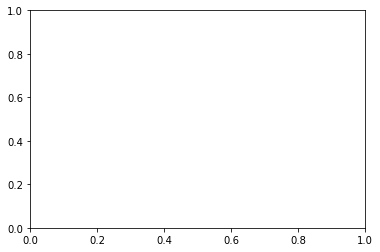

In [6]:
for name in histograms:
    print (name)
    histo_sig = output_sig[name]
    histo_back = output_back[name]
    #rebinning
    if name == "met":
        new_met_bins = hist.Bin('pt', r'MET (Tight Selection)', 26, 248, 1600)
        histo_sig = histo_sig.rebin('pt', new_met_bins)
        histo_back = histo_back.rebin('pt', new_met_bins)
    if name == "ht":
        new_ht_bins = hist.Bin('pt', r'HT (Tight Selection)', 25, 300, 2000)
        histo_sig = histo_sig.rebin('pt', new_ht_bins)
        histo_back = histo_back.rebin('pt', new_ht_bins)
    if name == "njets":
        new_nj_bins = hist.Bin('multiplicity', r'nJets (Tight Selection)', 16, -0.5, 15.5)
        histo_sig = histo_sig.rebin('multiplicity', new_nj_bins)
        histo_back = histo_back.rebin('multiplicity', new_nj_bins)
    if name == "bjets":
        new_bj_bins = hist.Bin('multiplicity', r'nBJets (Tight Selection)', 7, -0.5, 6.5)
        histo_sig = histo_sig.rebin('multiplicity', new_bj_bins)
        histo_back = histo_back.rebin('multiplicity', new_bj_bins)
    if name == "max_mt_b_met":
        new_mmbm_bins = hist.Bin('mass', r' max(mt(b,MET)) (Tight Selection)', 25, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm_bins)
        histo_back = histo_back.rebin('mass', new_mmbm_bins)  
    if name == "min_mt_b_met":
        new_mmbm_bins = hist.Bin('mass', r' min(mt(b,MET)) (Tight Selection)', 25, 0, 2500)
        histo_sig = histo_sig.rebin('mass', new_mmbm_bins)
        histo_back = histo_back.rebin('mass', new_mmbm_bins)   
    if name == "min_dphi_met_j":
        new_mdmj_bins = hist.Bin('phi', r' $|min(\Delta \Phi$(MET, lead jet))| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmj_bins)
        histo_back = histo_back.rebin('phi', new_mdmj_bins)
    if name == "min_dphi_met_j3":
        new_mdmj3_bins = hist.Bin('phi', r' $|min(\Delta \Phi$(MET, lead 3 jets))| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmj3_bins)
        histo_back = histo_back.rebin('phi', new_mdmj3_bins)
    if name == "min_dphi_met_j4":
        new_mdmj4_bins = hist.Bin('phi', r' $|min(\Delta \Phi$(MET, lead 4 jets))| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmj4_bins)
        histo_back = histo_back.rebin('phi', new_mdmj4_bins)
    if name == "min_dphi_met_wmch":
        new_mdmw_bins = hist.Bin('phi', r' $|min(\Delta \Phi$(MET, W/H))|(Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmw_bins)
        histo_back = histo_back.rebin('phi', new_mdmw_bins)
    if name == "min_dphi_met_wmdh":
        new_mdmw_bins = hist.Bin('phi', r' $|min(\Delta \Phi$(MET, W/H))|(Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_mdmw_bins)
        histo_back = histo_back.rebin('phi', new_mdmw_bins)
    if name == "dphi_H_leadj":
        new_dphj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, lead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphj_bins)
        histo_back = histo_back.rebin('phi', new_dphj_bins)
    if name == "dphi_H_leadbj":
        new_dphbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, lead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphbj_bins)
        histo_back = histo_back.rebin('phi', new_dphbj_bins)
    if name == "dphi_H_leadnbj":
        new_dphnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, lead non bjet)|(Tight Selection) ', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphnbj_bins)
        histo_back = histo_back.rebin('phi', new_dphnbj_bins)
    if name == "dphi_W_leadj":
        new_dpwj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, lead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwj_bins)
        histo_back = histo_back.rebin('phi', new_dpwj_bins)
    if name == "dphi_W_leadbj":
        new_dpwbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, lead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwbj_bins)
        histo_back = histo_back.rebin('phi', new_dpwbj_bins)
    if name == "dphi_W_leadnbj":
        new_dpwnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, lead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwnbj_bins)
        histo_back = histo_back.rebin('phi', new_dpwnbj_bins)
    if name == "dphi_H_subleadj":
        new_dphsj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, sublead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphsj_bins)
        histo_back = histo_back.rebin('phi', new_dphsj_bins)
    if name == "dphi_H_subleadbj":
        new_dphsbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, sublead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphsbj_bins)
        histo_back = histo_back.rebin('phi', new_dphsbj_bins)
    if name == "dphi_H_subleadnbj":
        new_dphsnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(H, sublead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dphsnbj_bins)
        histo_back = histo_back.rebin('phi', new_dphsnbj_bins)
    if name == "dphi_W_subleadj":
        new_dpwsj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, sublead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwsj_bins)
        histo_back = histo_back.rebin('phi', new_dpwsj_bins)
    if name == "dphi_W_subleadbj":
        new_dpwsbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, sublead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwsbj_bins)
        histo_back = histo_back.rebin('phi', new_dpwsbj_bins)
    if name == "dphi_W_subleadnbj":
        new_dpwsnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(W, sublead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpwsnbj_bins)
        histo_back = histo_back.rebin('phi', new_dpwsnbj_bins)
    if name == "dr_H_leadj":
        new_drhj_bins = hist.Bin('r', r' $|\Delta R$(H, lead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhj_bins)
        histo_back = histo_back.rebin('r', new_drhj_bins)
    if name == "dr_H_leadbj":
        new_drhbj_bins = hist.Bin('r', r' $|\Delta R$(H, lead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhbj_bins)
        histo_back = histo_back.rebin('r', new_drhbj_bins)
    if name == "dr_H_leadnbj":
        new_drhnbj_bins = hist.Bin('r', r' $|\Delta R$(H, lead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhnbj_bins)
        histo_back = histo_back.rebin('r', new_drhnbj_bins)
    if name == "dr_W_leadj":
        new_drwj_bins = hist.Bin('r', r' $|\Delta R$(W, lead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwj_bins)
        histo_back = histo_back.rebin('r', new_drwj_bins)
    if name == "dr_W_leadbj":
        new_drwbj_bins = hist.Bin('r', r' $|\Delta R$(W, lead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwbj_bins)
        histo_back = histo_back.rebin('r', new_drwbj_bins)
    if name == "dr_W_leadnbj":
        new_drwnbj_bins = hist.Bin('r', r' $|\Delta R$(W, lead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwnbj_bins)
        histo_back = histo_back.rebin('r', new_drwnbj_bins)
    if name == "dr_H_subleadj":
        new_drhsj_bins = hist.Bin('r', r' $|\Delta R$(H, sublead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhsj_bins)
        histo_back = histo_back.rebin('r', new_drhsj_bins)
    if name == "dr_H_subleadbj":
        new_drhsbj_bins = hist.Bin('r', r' $|\Delta R$(H, sublead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhsbj_bins)
        histo_back = histo_back.rebin('r', new_drhsbj_bins)
    if name == "dr_H_subleadnbj":
        new_drhsnbj_bins = hist.Bin('r', r' $|\Delta R$(H, sublead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drhsnbj_bins)
        histo_back = histo_back.rebin('r', new_drhsnbj_bins)
    if name == "dr_W_subleadj":
        new_drwsj_bins = hist.Bin('r', r' $|\Delta R$(W, sublead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwsj_bins)
        histo_back = histo_back.rebin('r', new_drwsj_bins)
    if name == "dr_W_subleadbj":
        new_drwsbj_bins = hist.Bin('r', r' $|\Delta R$(W, sublead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwsbj_bins)
        histo_back = histo_back.rebin('r', new_drwsbj_bins)
    if name == "dr_W_subleadnbj":
        new_drwsnbj_bins = hist.Bin('r', r' $|\Delta R$(W, sublead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('r', new_drwsnbj_bins)
        histo_back = histo_back.rebin('r', new_drwsnbj_bins)
    if name == "dphi_MET_leadj":
        new_dpmj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmj_bins)
        histo_back = histo_back.rebin('phi', new_dpmj_bins)
    if name == "dphi_MET_leadbj":
        new_dpmbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmbj_bins)
        histo_back = histo_back.rebin('phi', new_dpmbj_bins)
    if name == "dphi_MET_leadnbj":
        new_dpmnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmnbj_bins)
        histo_back = histo_back.rebin('phi', new_dpmnbj_bins)
    if name == "dphi_MET_subleadj":
        new_dpmsj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, sublead jet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmsj_bins)
        histo_back = histo_back.rebin('phi', new_dpmsj_bins)
    if name == "dphi_MET_subleadbj":
        new_dpmsbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, sublead bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmsbj_bins)
        histo_back = histo_back.rebin('phi', new_dpmsbj_bins)
    if name == "dphi_MET_subleadnbj":
        new_dpmsnbj_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, sublead non bjet)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmsnbj_bins)
        histo_back = histo_back.rebin('phi', new_dpmsnbj_bins)
    if name == "dphi_MET_leadH":
        new_dpmh_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead H)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmh_bins)
        histo_back = histo_back.rebin('phi', new_dpmh_bins)
    if name == "dphi_MET_leadW":
        new_dpmw_bins = hist.Bin('phi', r' $|\Delta \Phi$(MET, lead W)| (Tight Selection)', 20, 0 , 4)
        histo_sig = histo_sig.rebin('phi', new_dpmw_bins)
        histo_back = histo_back.rebin('phi', new_dpmw_bins)
    savefig(histo_sig, histo_back,outdir, name)
    savefigshape(histo_sig, histo_back,outdir, name)